<a href="https://colab.research.google.com/github/pablo-arantes/Cloud-Bind/blob/main/Uni_Dock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Hi there!**

This is a Jupyter notebook for running molecular docking calculations with Uni-Dock, a GPU-accelerated molecular docking program.

The main goal of this notebook is to demonstrate how to harness the power of cloud-computing to perform drug binding structure prediction in a cheap and yet feasible fashion.

---

 **This notebook is NOT a standard protocol for docking calculations and MD simulations!** It is just simple docking pipeline illustrating each step of a docking and MD protocol.

---


**Bugs**
- If you encounter any bugs, please report the issue to https://github.com/pablo-arantes/Cloud-Bind/issues

**Acknowledgments**
- We would like to thank the [Uni-Dock](https://github.com/dptech-corp/Uni-Dock) team for doing an excellent job open sourcing the software.
- We would like to thank the [Roitberg](https://roitberg.chem.ufl.edu/) team for developing the fantastic [TorchANI](https://github.com/aiqm/torchani).
- We would like to thank [@ruiz_moreno_aj](https://twitter.com/ruiz_moreno_aj) for his work on [Jupyter Dock](https://github.com/AngelRuizMoreno/Jupyter_Dock)
- We would like to thank the ChemosimLab ([@ChemosimLab](https://twitter.com/ChemosimLab)) team for their incredible [ProLIF](https://prolif.readthedocs.io/en/latest/index.html#) (Protein-Ligand Interaction Fingerprints) tool.
- We would like to thank the [OpenBPMD](https://github.com/Gervasiolab/OpenBPMD) team for their open source implementation of binding pose metadynamics (BPMD).
- Also, credit to [David Koes](https://github.com/dkoes) for his awesome [py3Dmol](https://3dmol.csb.pitt.edu/) plugin.
- Finally, we would like to thank [Making it rain](https://github.com/pablo-arantes/making-it-rain) team, **Pablo R. Arantes** ([@pablitoarantes](https://twitter.com/pablitoarantes)), **Marcelo D. Polêto** ([@mdpoleto](https://twitter.com/mdpoleto)), **Conrado Pedebos** ([@ConradoPedebos](https://twitter.com/ConradoPedebos)) and **Rodrigo Ligabue-Braun** ([@ligabue_braun](https://twitter.com/ligabue_braun)), for their amazing work.
- A Cloud-Bind by **Pablo R. Arantes** ([@pablitoarantes](https://twitter.com/pablitoarantes)), **Conrado Pedebos** ([@ConradoPedebos](https://twitter.com/ConradoPedebos)) and **Rodrigo Ligabue-Braun** ([@ligabue_braun](https://twitter.com/ligabue_braun)).


- For related notebooks see: [Cloud-Bind](https://github.com/pablo-arantes/Cloud-Bind)

In [ ]:
#@title **Install Conda Colab**
#@markdown It will restart the kernel (session), don't worry.
!pip install -q condacolab
import condacolab
condacolab.install_from_url("https://github.com/conda-forge/miniforge/releases/download/25.3.1-0/Miniforge3-Linux-x86_64.sh")

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/25.3.1-0/Miniforge3-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:06
🔁 Restarting kernel...


In [ ]:
#@title **Install dependencies**
#@markdown It will take a few minutes, please, drink a coffee and wait. ;-)
# install dependencies
%%capture
import sys
import tarfile
import os

import subprocess
import sys

commands = [
    "pip install numpy==2.0.0",
    "pip -q install py3Dmol",
    "pip install git+https://github.com/pablo-arantes/biopandas",
    "pip install bio",
    "mamba install -c conda-forge pdbfixer -y",
    "mamba install -c conda-forge parmed -y",
    "mamba install -c conda-forge openbabel -y",
    "wget https://github.com/dptech-corp/Uni-Dock/releases/download/1.1.0/unidock-1.1.0-cuda120-linux-x86_64",
    "mv unidock-1.1.0-cuda120-linux-x86_64 unidock",
    "chmod +x unidock",
    "wget https://github.com/rdk/p2rank/releases/download/2.4/p2rank_2.4.tar.gz",
    "mamba install -c conda-forge pymol-open-source -y",
    "pip install posebusters --upgrade"
]


for cmd in commands:
    subprocess.run(cmd, shell=True)

file = tarfile.open('p2rank_2.4.tar.gz')
file.extractall('/content/')
file.close()
os.remove('p2rank_2.4.tar.gz')


#load dependencies
import parmed as pmd
from biopandas.pdb import PandasPdb
import urllib.request
import numpy as np
import py3Dmol
import platform
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import scipy.stats as statsz
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata
import seaborn as sb
from statistics import mean, stdev
from matplotlib import colors

## Using Google Drive to store simulation data

Google Colab does not allow users to keep data on their computing nodes. However, we can use Google Drive to read, write, and store our simulations files. Therefore, we suggest to you to:

1.   Create a folder in your own Google Drive and copy the necessary input files there.
2.   Copy the path of your created directory. We will use it below.

In [ ]:
#@title ### **Import Google Drive**
#@markdown Click in the "Run" buttom to make your Google Drive accessible.
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#@title **Check if you correctly allocated GPU nodes**

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)


---
# **Loading the necessary input files**

At this point, we should have all libraries and dependencies installed.

**Important**: Make sure the PDB file points to the correct structure.

Below, you should provide the names of all input files and the pathway of your Google Drive folder containing them.

**Please, don't use spaces in the files and folders names, i.e. MyDrive/protein_ligand and so on.**

In [ ]:
#@title **Please, provide the necessary input files below for receptor**:
#@markdown **Important:** Run the cell to prepare your receptor and select your reference residue for the construction of an optimal box size for the docking calculations.

#@markdown Choose between uploading your own PDB file (pdb_file) or using a PDB ID (Query_PDB_ID) to download the correct file. The appropriate chains can be selected as well.

from openmm.app.pdbfile import PDBFile

import requests
import warnings
warnings.filterwarnings('ignore')
import os
from Bio.PDB import PDBParser, PDBIO, Select
from Bio.PDB import is_aa
import pandas as pd
from pdbfixer import PDBFixer

Google_Drive_Path = '/content/drive/MyDrive/' #@param {type:"string"}
workDir = Google_Drive_Path

workDir2 = os.path.join(workDir)
workDir_check = os.path.exists(workDir2)
if workDir_check == False:
  os.mkdir(workDir2)
else:
  pass

if os.path.exists(os.path.join(workDir, "name_residues.txt")):
  os.remove(os.path.join(workDir, "name_residues.txt"))
  os.remove(os.path.join(workDir,"name_residues_receptor.txt"))
else:
  pass

temp = os.path.join(workDir, "temp.pdb")
receptor = os.path.join(workDir, "receptor.pdb")
ligand = os.path.join(workDir, "ligand.sdf")

# Choose PDB source: Upload or PDB ID
PDB_Source = "Uploaded_PDB" # @param ["PDB_ID","Uploaded_PDB"]

if PDB_Source == "Uploaded_PDB":
    pdb_file = '3D11.pdb' #@param {type:"string"}
    outfnm = os.path.join(workDir, pdb_file)

elif PDB_Source == "PDB_ID":
    Query_PDB_ID = '3HTB' #@param {type:"string"}
    pdbfn = Query_PDB_ID + ".pdb"
    url = 'https://files.rcsb.org/download/' + pdbfn
    outfnm = os.path.join(workDir, pdbfn)
    try:
      response = requests.get(url)
      response.raise_for_status()  # Raise an exception for bad responses (4xx or 5xx)
      with open(outfnm, 'wb') as outfile:
          outfile.write(response.content)
      print(f"File downloaded to: {outfnm}")
      print(f"File size: {os.path.getsize(outfnm)} bytes")
    except requests.exceptions.RequestException as e:
      print(f"Error downloading PDB file: {e}")

print(outfnm)
# Read the PDB file
ppdb = PandasPdb().read_pdb(outfnm)
selected_chains = ['A'] # @param {"type":"raw"}

# Check if selected_chains is empty or not provided:
if 'selected_chains' not in locals() or not selected_chains:
    print("No chains selected, processing all chains.")
    # Filter chains for ATOM and HETATM records
    ppdb.df['ATOM'] = ppdb.df['ATOM']
else:
    ppdb.df['ATOM'] = ppdb.df['ATOM'][ppdb.df['ATOM']['chain_id'].isin(selected_chains)]
    ppdb.df['HETATM'] = ppdb.df['HETATM'][ppdb.df['HETATM']['chain_id'].isin(selected_chains)]

# Remove water molecules (HOH)
ppdb.df['HETATM'] = ppdb.df['HETATM'][ppdb.df['HETATM']['residue_name'] != 'HOH']

# Save the filtered PDB file
ppdb.to_pdb(path=temp, records=['ATOM', 'HETATM'], gz=False, append_newline=True)

# Prepare receptor (additional filtering)
ppdb = PandasPdb().read_pdb(outfnm)

# Remove water molecules (HOH)
ppdb.df['HETATM'] = ppdb.df['HETATM'][ppdb.df['HETATM']['residue_name'] != 'HOH']

# Remove OXT atoms and hydrogen atoms
ppdb.df['ATOM'] = ppdb.df['ATOM'][ppdb.df['ATOM']['atom_name'] != 'OXT']
ppdb.df['ATOM'] = ppdb.df['ATOM'][ppdb.df['ATOM']['element_symbol'] != 'H']

# Save the filtered receptor PDB file
ppdb.to_pdb(path=receptor, records=['ATOM', 'HETATM'], gz=False, append_newline=True)

fixer = PDBFixer(filename=receptor)
fixer.removeHeterogens()
fixer.findMissingResidues()
fixer.findMissingAtoms()
fixer.addMissingAtoms()
fixer.addMissingHydrogens(pH=7.4)
PDBFile.writeFile(fixer.topology, fixer.positions, open(receptor, 'w'))


path = '/content/'


def is_het(residue):
    res = residue.id[0]
    return res != " " and res != "W"

def aa(residue):
    res = residue.id[0]
    return res != "W"


class ResidueSelect(Select):
    def __init__(self, chain, residue):
        self.chain = chain
        self.residue = residue

    def accept_chain(self, chain):
        return chain.id == self.chain.id

    def accept_residue(self, residue):
        return residue == self.residue and aa(residue)

def extract_ligands(path):
    pdb = PDBParser().get_structure(temp, temp)
    io = PDBIO()
    io.set_structure(pdb)
    i = 1
    name_residues = []
    for model in pdb:
      for chain in model:
        for residue in chain:
          if not aa(residue):
            continue
          # print(f"{chain[i].resname} {i}")
          name_residues.append(residue)
          print((f"saving {residue}"), file=open(os.path.join(workDir, "name_residues.txt"), "a",))
          i += 1

extract_ligands(path)

def extract_ligands2(path):
    pdb = PDBParser().get_structure(receptor, receptor)
    io = PDBIO()
    io.set_structure(pdb)
    i2 = 1
    name_residues2 = []
    for model in pdb:
      for chain in model:
        for residue in chain:
          if not aa(residue):
            continue
          # print(f"{chain[i].resname} {i}")
          name_residues2.append(residue)
          print((f"saving {residue}"), file=open(os.path.join(workDir, "name_residues_receptor.txt"), "a",))
          i2 += 1

extract_ligands2(path)


dataset = pd.read_csv(os.path.join(workDir, 'name_residues.txt'), delimiter = " ", header=None)
df = pd.DataFrame(dataset)
df = df.iloc[:, [2]]
new = df.to_numpy()

dataset2 = pd.read_csv(os.path.join(workDir, 'name_residues_receptor.txt'), delimiter = " ", header=None)
df2 = pd.DataFrame(dataset2)
df2 = df2.iloc[:, [2]]
new2 = df2.to_numpy()

b = 1
res_number = []
for j in new2:
  res_number.append(b)
  b += 1

print("Residue" + " - "  + "Number" )
a = 1
for j in new:
  print(', '.join(j) + " - "  + str(a))
  a += 1

In [ ]:
#@title **Predict ligand-binding pockets from your protein structure using P2Rank**:
#@markdown **P2Rank** is a stand-alone command line program that predicts ligand-binding pockets from a protein structure. It achieves high prediction success rates without relying on an external software for computation of complex features or on a database of known protein-ligand templates.
#@markdown P2Rank makes predictions by scoring and clustering points on the protein's solvent accessible surface. Ligandability score of individual points is determined by a machine learning based model trained on the dataset of known protein-ligand complexes. For more details see [here](https://github.com/rdk/p2rank).

import subprocess
import csv

output_p2rank = os.path.join(workDir, "output_p2rank")
p2rank = "/content/p2rank_2.4/prank predict -f " + str(receptor) + " -o " + str(output_p2rank)
original_stdout = sys.stdout
with open('p2rank.sh', 'w') as f:
  sys.stdout = f
  print(p2rank)
  sys.stdout = original_stdout
subprocess.run(["chmod 700 p2rank.sh"], shell=True)
subprocess.run(["./p2rank.sh"], shell=True,)

with open(os.path.join(workDir, "output_p2rank/receptor.pdb_predictions.csv"), 'r') as file:
  csvreader = csv.reader(file)
  residue = []
  score = []
  center_x = []
  center_y = []
  center_z = []
  for row in csvreader:
    residue.append(row[9:10])
    score.append(row[2:3])
    center_x.append(row[6:7])
    center_y.append(row[7:8])
    center_z.append(row[8:9])

for i in range(1,len(residue)):
  file = str((residue[i])[0]).split()
  score_end = str((score[i])[0]).split()
  center_x_end = str((center_x[i])[0]).split()
  center_y_end = str((center_y[i])[0]).split()
  center_z_end = str((center_z[i])[0]).split()
  print("Pocket " + str(i))
  print("Score = " + score_end[0])
  final_residues = []
  for i in range(0,len(file)):
    test = file[i]
    final_residues.append(int(test[2:]))
  print("Selected Residues = " + str(final_residues))
  print("Center x = "+ str(center_x_end[0]), "Center y = "+ str(center_y_end[0]), "Center z = "+ str(center_z_end[0]) + "\n")

Pocket 1
Score = 13.61
Selected Residues = [10, 103, 104, 105, 106, 107, 108, 11, 137, 138, 141, 142, 145, 18, 20, 21, 22, 24, 26, 30, 31, 32, 35, 70, 73, 74, 77]
Center x = 26.9061 Center y = -13.2369 Center z = -10.2065

Pocket 2
Score = 3.53
Selected Residues = [102, 103, 111, 118, 121, 153, 78, 84, 87, 88, 91, 99]
Center x = 22.5540 Center y = -25.4592 Center z = -2.7213

Pocket 3
Score = 2.13
Selected Residues = [100, 3, 71, 75, 88, 96, 97]
Center x = 14.4580 Center y = -23.6512 Center z = -13.2428



In [ ]:
#@title **Please, provide the pocket or residue number for the selection**:
#@markdown **Important:** The selected pocket or residues will be used as a reference for the construction of an optimal box size for the ligand during the docking. If you want to select more than one residue, please, use comma to separte the numbers (i.e. 147,150,155,160). **Please, DO NOT USE SPACES BETWEEN THEM.**

import re
import csv

if os.path.exists(os.path.join(workDir, "name_residue.txt")):
  os.remove(os.path.join(workDir, "name_residue.txt"))
else:
  pass

# Python code to convert string to list
def Convert(string):
	li = list(string.split(","))
	return li

def extract_ligands(path,residues):
    pdb = PDBParser().get_structure(temp, temp)
    io = PDBIO()
    io.set_structure(pdb)
    i = 1
    name_residues = []
    for model in pdb:
      for chain in model:
        for residue in chain:
          if not aa(residue):
            continue
          if i == int(residues):
            # print(residues)
            print((f"saving {residue}"), file=open(os.path.join(workDir, "name_residue.txt"), "a",))
            io.save(f"res_{i}_certo.pdb", ResidueSelect(chain, residue))
          i += 1

Selection = "Pocket" #@param ["Pocket", "Residues"]

number = '2' #@param {type:"string"}

if Selection == "Pocket":
  file = str((residue[int(number)])[0]).split()
  score_end = str((score[int(number)])[0]).split()
  center_x_end = str((center_x[int(number)])[0]).split()
  center_y_end = str((center_y[int(number)])[0]).split()
  center_z_end = str((center_z[int(number)])[0]).split()
  center_x_gnina = float(center_x_end[0])
  center_y_gnina = float(center_y_end[0])
  center_z_gnina = float(center_z_end[0])
  print("Pocket " + str(number))
  print("Score = " + score_end[0])
  print("Center x = "+ str(center_x_end[0]), "Center y = "+ str(center_y_end[0]), "Center z = "+ str(center_z_end[0]) + "\n")
  final_residues = []
  for i in range(0,len(file)):
    test = file[i]
    final_residues.append(int(test[2:]))
  residues_num = final_residues
else:
  residues_num = Convert(number)

filenames=[]
for k in range(0, len(residues_num)):
  extract_ligands(path, residues_num[k])
  filenames.append(f"res_{residues_num[k]}_certo.pdb")


with open('selection_merge.pdb', 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            for line in infile:
                outfile.write(line)

# reading each line from original
# text file
file1 = open('/content/selection_merge.pdb', 'r')
file2 = open('/content/selection_merge_end.pdb','w')

for line in file1.readlines():

    # reading all lines that begin
    # with "TextGenerator"
    x = re.findall("^END", line)

    if not x:
        file2.write(line)

# close and save the files
file1.close()
file2.close()

dataset = pd.read_csv(os.path.join(workDir, "name_residue.txt"), delimiter = " ", header=None)
df = pd.DataFrame(dataset)
df = df.iloc[:, [2]]
new = df.to_numpy()

print("Selected Residue" + " - "  + "Number" )
for j, i in zip(new, range(0, len(residues_num))):
# for j in new:
  print(', '.join(j) + " - "  + str(residues_num[i]))
res_box = '/content/selection_merge_end.pdb'

Pocket 2
Score = 3.53
Center x = 22.5540 Center y = -25.4592 Center z = -2.7213

Selected Residue - Number
GLN - 102
VAL - 103
VAL - 111
LEU - 118
LEU - 121
PHE - 153
ILE - 78
LEU - 84
VAL - 87
TYR - 88
LEU - 91
ALA - 99


# **Calculating docking box for Uni-DocK**

The docking box is a crucial parameter for accurate docking calculations. To facilitate both convenience and precision, the GetBox-PyMOL script can be used to determine the appropriate grid box for the docking process.

The docking box can be calculated based on the geometric center of the ligand or the geometric center of the amino acid residues. As illustrated in the example below, the *extending* parameters should be defined by the user.

You can observe the difference in geometric centers in the following pictures:

**Geometric Center of Ligand**
![](https://raw.githubusercontent.com/pablo-arantes/Cloud-Bind/main/ligand_box.jpg)

**Geometric Center of Amino Acids Residues**
![](https://raw.githubusercontent.com/pablo-arantes/Cloud-Bind/main/residues_box.jpg)

In [ ]:
#@title **Setting the grid box**:
#@markdown Next, we will utilize ViewProtGrid to visualize the protein, the binding site residues, and a grid box of variable size and position. This grid box can be manipulated using the **extending** parameters.

Extending_value = 0.1 #@param {type:"slider", min:0.1, max:10, step:0.1}

from pymol import cmd

def getbox(selection='sele', extending = 6.0, software='vina'):

    ([minX, minY, minZ],[maxX, maxY, maxZ]) = cmd.get_extent(selection)

    minX = minX - float(extending)
    minY = minY - float(extending)
    minZ = minZ - float(extending)
    maxX = maxX + float(extending)
    maxY = maxY + float(extending)
    maxZ = maxZ + float(extending)

    SizeX = maxX - minX
    SizeY = maxY - minY
    SizeZ = maxZ - minZ
    CenterX =  (maxX + minX)/2
    CenterY =  (maxY + minY)/2
    CenterZ =  (maxZ + minZ)/2

    cmd.delete('all')

    if software == 'vina':
        return {'center_x':CenterX,'center_y': CenterY, 'center_z': CenterZ},{'size_x':SizeX,'size_y': SizeY,'size_z': SizeZ}
        print(CenterX)
    elif software == 'ledock':
        return {'minX':minX, 'maxX': maxX},{'minY':minY, 'maxY':maxY}, {'minZ':minZ,'maxZ':maxZ}
    elif software == 'both':
        return ({'center_x':CenterX,'center_y': CenterY, 'center_z': CenterZ},{'size_x':SizeX,'size_y': SizeY,'size_z': SizeZ}),({'minX':minX, 'maxX': maxX},{'minY':minY, 'maxY':maxY}, {'minZ':minZ,'maxZ':maxZ})

    else:
        print('software options must be "vina", "ledock" or "both"')


# Convert each string to an integer, add 1, and convert back to a string
residues_mod = [str(int(num) + 1) for num in residues_num]

cmd.load(filename=temp,format='pdb',)
sele = 'resi '+ '+'.join([str(x) for x in residues_mod])
center, size= getbox(selection=sele, extending=float(Extending_value), software='vina')
cmd.delete('all')
centerX = float(center['center_x'])
centerY = float(center['center_y'])
centerZ = float(center['center_z'])
sizeX = float(size['size_x'])
sizeY = float(size['size_y'])
sizeZ = float(size['size_z'])

print(f"Center_X = {centerX:.4f}")
print(f"Center_Y = {centerY:.4f}")
print(f"Center_Z = {centerZ:.4f}")
print(f"Size_X = {sizeX:.4f}")
print(f"Size_Y = {sizeY:.4f}")
print(f"Size_Z = {sizeZ:.4f}")

def definegrid(object,bxi,byi,bzi,bxf,byf,bzf):
  object.addBox({'center':{'x':bxi,'y':byi,'z':bzi},'dimensions': {'w':bxf,'h':byf,'d':bzf},'color':'blue','opacity': 0.6})

#Next, we define how the protein will be shown in py3Dmol
#Note that we are also adding a style representation for active site residues
def viewprot(object,prot_PDBfile):
  mol1 = open(prot_PDBfile, 'r').read()
  object.addModel(mol1,'pdb')
  object.setStyle({'cartoon': {'color':'white'}})

#Lastly, we combine the box grid and protein into a single viewer
def viewprotgrid(prot_PDBfile,resids,bxi,byi,bzi,bxf=10,byf=10,bzf=10):
  mol_view = py3Dmol.view(1000,600)
  definegrid(mol_view,bxi,byi,bzi,bxf,byf,bzf)
  viewprot(mol_view,prot_PDBfile)
  mol_view.addModel(open(resids,'r').read(),format='mol2')
  ref_m = mol_view.getModel()
  ref_m.setStyle({},{'stick':{'colorscheme':'greenCarbon','radius':0.2}})
  mol_view.setBackgroundColor('0xffffff')
  mol_view.zoomTo()
  mol_view.show()

viewprotgrid(receptor,res_box,centerX,centerY,centerZ,sizeX,sizeY,sizeZ)

Center_X = 20.0670
Center_Y = -25.2950
Center_Z = -2.7880
Size_X = 20.7760
Size_Y = 21.9280
Size_Z = 23.8480


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Smiles: CCCC1=CC=CC=C1O


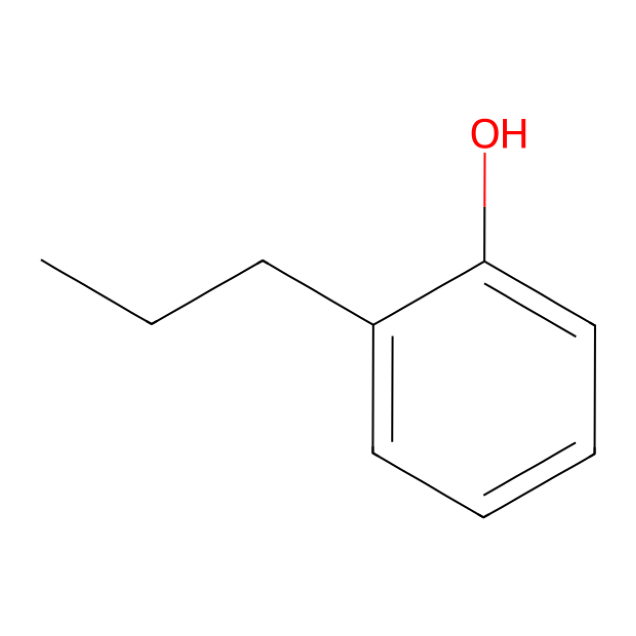

In [ ]:
#@title **Please, provide the necessary input files for the ligand**:

#@markdown Geometry optimization for the ligand 3D structure, using RDKit.


#@markdown Type the smiles or filename (PDB and MOL formats) of your molecule. **Ex: C=CC(=O)OC, molecule.pdb or molecule.mol**

#@markdown Just remind you that if you want to use pdb or mol file, you should first upload the file here in Colab or in your Google Drive.

#@markdown If you don't know the exactly smiles, please, check at https://pubchem.ncbi.nlm.nih.gov/

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdMolTransforms
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdDepictor
from IPython.display import SVG
import ipywidgets as widgets
import rdkit
from rdkit.Chem.Draw import IPythonConsole
AllChem.SetPreferCoordGen(True)
from IPython.display import Image
from openbabel import pybel
import matplotlib.image as mpimg

import os

import py3Dmol


Type = "smiles" #@param ["smiles", "pdb", "mol"]

smiles_or_filename = 'CCCC1=CC=CC=C1O' #@param {type:"string"}

if Type == "smiles":
  Smiles = smiles_or_filename
  smiles_fig = Chem.MolFromSmiles(Smiles)
  hmol = Chem.AddHs(smiles_fig)
  AllChem.EmbedMolecule(hmol)
  hmol.GetConformer(0)
  mp = AllChem.MMFFGetMoleculeProperties(hmol)
  ff = AllChem.MMFFGetMoleculeForceField(hmol, mp)
  # Optimize
  AllChem.OptimizeMoleculeConfs(hmol, ff, numThreads=1, maxIters=1000)
  AllChem.MolToMolFile(hmol, (os.path.join(workDir, "ligand_min.mol")))
  AllChem.MolToPDBFile(hmol, (os.path.join(workDir, "ligand_min.pdb")))
  ligand_mol=os.path.join(workDir, "ligand_min.mol")
  os.system("obabel -i mol " + str(ligand_mol) + " -o pdbqt -O " + str(ligand) + " -xh --partialcharge")

elif Type == "pdb":
  pdb_name = os.path.join(workDir, smiles_or_filename)
  mol= [m for m in pybel.readfile(filename=pdb_name, format='pdb')][0]
  out=pybel.Outputfile(filename='mol.mol',format='mol',overwrite=True)
  out.write(mol)
  out.close()
  mol = Chem.MolFromMolFile('mol.mol')
  Smiles = Chem.MolToSmiles(mol)
  smiles_fig = Chem.MolFromSmiles(Smiles)
  hmol = Chem.AddHs(smiles_fig)
  AllChem.EmbedMolecule(hmol)
  hmol.GetConformer(0)
  mp = AllChem.MMFFGetMoleculeProperties(hmol)
  ff = AllChem.MMFFGetMoleculeForceField(hmol, mp)
  # Optimize
  AllChem.OptimizeMoleculeConfs(hmol, ff, numThreads=1, maxIters=1000)
  AllChem.MolToMolFile(hmol, (os.path.join(workDir, "ligand_min.mol")))
  AllChem.MolToPDBFile(hmol, (os.path.join(workDir, "ligand_min.pdb")))
  ligand_mol=os.path.join(workDir, "ligand_min.mol")
  os.system("obabel -i mol " + str(ligand_mol) + " -o pdbqt -O " + str(ligand) + " -xh --partialcharge")
else:
  mol_name = os.path.join(workDir, smiles_or_filename)
  mol = Chem.MolFromMolFile(mol_name)
  Smiles = Chem.MolToSmiles(mol)
  smiles_fig = Chem.MolFromSmiles(Smiles)
  hmol = Chem.AddHs(smiles_fig)
  AllChem.EmbedMolecule(hmol)
  hmol.GetConformer(0)
  mp = AllChem.MMFFGetMoleculeProperties(hmol)
  ff = AllChem.MMFFGetMoleculeForceField(hmol, mp)
  # Optimize
  AllChem.OptimizeMoleculeConfs(hmol, ff, numThreads=1, maxIters=1000)
  AllChem.MolToMolFile(hmol, (os.path.join(workDir, "ligand_min.mol")))
  AllChem.MolToPDBFile(hmol, (os.path.join(workDir, "ligand_min.pdb")))
  ligand_mol=os.path.join(workDir, "ligand_min.mol")
  os.system("obabel -i mol " + str(ligand_mol) + " -o pdbqt -O " + str(ligand) + " -xh --partialcharge")


print("Smiles: " + str(Smiles))
smi = Draw.MolToFile(smiles_fig, size=(600, 600), filename=os.path.join(workDir,str(Smiles) + '.png'))
img = mpimg.imread(os.path.join(workDir,str(Smiles) + '.png'))
plt.figure(figsize = (8,8))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
#@title **Ligand Visualization**:
#@markdown Now the ligand has been optimized, it would be recomended to visualize and check the ligand.

view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.05})

# view.addModel(open(receptor,'r').read(),format='pdb')
# Prot=view.getModel()
# Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
# view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})

view.addModel(open(os.path.join(workDir, "ligand_min.mol"),'r').read(),format='pdbqt')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'greenCarbon','radius':0.2}})

view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
#@title **Parameters for the docking calculation:**

#@markdown Explicit random seed:
seed = "0" #@param {type:"string"}

scoring = "vina" #@param ["vina", "vinardo"]


#@markdown **Advanced options** `--search_mode` is the recommended setting of `--exhaustiveness` and `--max_step`, with three combinations called `fast`, `balance`, and `detail`.

#@markdown - `fast` mode: `--exhaustiveness 128` & `--max_step 20`
#@markdown - `balance` mode: `--exhaustiveness 384` & `--max_step 40`
#@markdown - `detail` mode: `--exhaustiveness 512` & `--max_step 40`

#@markdown The larger `--exhaustiveness` and `--max_step`, the higher the computational complexity, the higher the accuracy, but the larger the computational cost.

search_mode = "fast" #@param ["fast", "balance", "detail"]
exhaustiveness = 128 #@param {type:"slider", min:8, max:512, step:8}
max_step = 20 #@param {type:"slider", min:0, max:40, step:5}

#@markdown Maximum number of binding modes to generate:
num_modes = 10 #@param {type:"slider", min:1, max:10, step:1}

import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

unidock = "./unidock --receptor " + str(receptor_pdbqt) + " --gpu_batch " + str(ligand) + " --search_mode " + str(search_mode) + " --scoring " + str(scoring) + " --center_x " + str(centerX) + " --center_y " + str(centerY) + " --center_z " + str(centerZ) + " --size_x " + str(sizeX) + " --size_y " + str(sizeY) + " --size_z " + str(sizeZ) + " --num_modes " + str(num_modes) + " --dir " + str(workDir) + " --seed " + str(seed) + " --max_step " + str(max_step) + " --exhaustiveness " + str(exhaustiveness)

original_stdout = sys.stdout # Save a reference to the original standard output
with open('unidock.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(unidock)
    sys.stdout = original_stdout # Reset the standard output to its original value
print(unidock)
!chmod 700 unidock.sh 2>&1 1>/dev/null
!bash unidock.sh

ligand_out=os.path.join(workDir, "ligand_out.pdbqt")
ligand_out_sdf=os.path.join(workDir, "ligand_out.sdf")
os.system("obabel -i pdbqt " + str(ligand_out) + " -o sdf -O " + str(ligand_out_sdf) + " -xh")


import gzip
v = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
v.setViewStyle({'style':'outline','color':'black','width':0.05})
v.addModel(open(receptor).read())
v.setStyle({'cartoon':{},'stick':{'colorscheme':'white','radius':.1}})
v.addModel(open(res_box).read())
v.setStyle({'model':1},{'stick':{'colorscheme':'dimgrayCarbon','radius':.175}})
v.addModelsAsFrames(open(ligand_out_sdf,'rt').read())
v.setStyle({'model':2},{'stick':{'colorscheme':'greenCarbon'}})
v.animate({'interval':1000})
v.zoomTo({'model':1})
v.rotate(90)

./unidock --receptor /content/3HTB/receptor.pdbqt --gpu_batch /content/3HTB/ligand.pdbqt --search_mode fast --scoring vina --center_x 20.066999912261963 --center_y -25.295000076293945 --center_z -2.7880001068115234 --size_x 20.775999259948733 --size_y 21.928000640869143 --size_z 23.848000717163085 --num_modes 10 --dir /content/3HTB --seed 0 --max_step 20 --exhaustiveness 128
Uni-Dock v1.1.0

If you used Uni-Dock in your work, please cite:               
 
Yu, Y., Cai, C., Wang, J., Bo, Z., Zhu, Z., & Zheng, H. (2023). 
Uni-Dock: GPU-Accelerated Docking Enables Ultralarge Virtual Screening. 
Journal of Chemical Theory and Computation.                    
https://doi.org/10.1021/acs.jctc.2c01145                       

Tang, S., Chen, R., Lin, M., Lin, Q., Zhu, Y., Ding, J., ... & Wu, J. (2022). 
Accelerating autodock vina with gpus. Molecules, 27(9), 3041. 
DOI 10.3390/molecules27093041                                 

J. Eberhardt, D. Santos-Martins, A. F. Tillack, and S. Forli  
Auto

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
#@title **Check New Poses Generated for a Given Target with PoseBusters**

#@markdown **PoseBusters** is a Python package designed to perform a series of standard quality checks using the well-established cheminformatics toolkit RDKit. The PoseBusters test suite validates the chemical and geometric consistency of ligands, including their stereochemistry, as well as the physical plausibility of intra- and intermolecular interactions such as the planarity of aromatic rings, bond lengths, and protein-ligand clashes.

#@markdown Here, we are using the dock mode. This is applicable for de novo generated molecules for a given receptor or for ligands that have been docked into a non-cognate receptor.

#@markdown **For more detailed information, please refer to the following publication:** https://doi.org/10.1039/D3SC04185A

from posebusters import PoseBusters
import pandas as pd

# Run PoseBusters
buster = PoseBusters(config="dock")
df = buster.bust([ligand_out_sdf], None, receptor)

# Reset index to remove multi-index (if present)
# df = df.reset_index()
df.reset_index(drop=True)
# Drop unnecessary columns ('file' and 'molecule') if they exist
columns_to_drop = ['file', 'molecule']
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')

# Insert 'pose' column at the first position
df.insert(loc=0, column='pose', value=range(1, len(df) + 1))

# Save the DataFrame to a CSV file (without 'file' and 'molecule' columns)
csv_file_path = os.path.join(workDir, 'posebusters_results.csv')
df.to_csv(csv_file_path, index=False)

# Check for False values in any column (excluding 'pose')
failed_poses = df[df.iloc[:, 1:].eq(False).any(axis=1)]

if failed_poses.empty:
    print("All poses successfully passed the validation.")
else:
    print("The following poses failed:")
    print(*failed_poses['pose'].tolist(), sep='\n') # Print values without index

print(f"DataFrame saved as {csv_file_path}")
df

All poses successfully passed the validation.
DataFrame saved as /content/3HTB/posebusters_results.csv


pose  mol_pred_loaded  \
file                         molecule position                          
/content/3HTB/ligand_out.sdf =        0            1             True   
                                      1            2             True   
                                      2            3             True   
                                      3            4             True   
                                      4            5             True   
                                      5            6             True   
                                      6            7             True   
                                      7            8             True   
                                      8            9             True   
                                      9           10             True   

                                                mol_cond_loaded  sanitization  \
file                         molecule position                                  
/content/3HTB/ligand_out.sdf =        0                    True          True   
                                      1                    True          True   
                                      2                    True          True   
                                      3                    True          True   
                                      4                    True          True   
                                      5                    True          True   
                                      6                    True          True   
                                      7                    True          True   
                                      8                    True          True   
                                      9                    True          True   

                                                inchi_convertible  \
file                         molecule position                      
/content/3HTB/ligand_out.sdf =        0                      True   
                                      1                      True   
                                      2                      True   
                                      3                      True   
                                      4                      True   
                                      5                      True   
                                      6                      True   
                                      7                      True   
                                      8                      True   
                                      9                      True   

                                                all_atoms_connected  \
file                         molecule position                        
/content/3HTB/ligand_out.sdf =        0                        True   
                                      1                        True   
                                      2                        True   
                                      3                        True   
                                      4                        True   
                                      5                        True   
                                      6                        True   
                                      7                        True   
                                      8                        True   
                                      9                        True   

                                                bond_lengths  bond_angles  \
file                         molecule position                              
/content/3HTB/ligand_out.sdf =        0                 True         True   
                                      1                 True         True   
                                      2                 True         True   
                                      3                 True         True   
                                      4               